# Mid Bootcamp Project - Regression
## Data Description

#### This dataset contains information of houses sold in King County, Washington, USA.
* **Sales data** - Price and date sold, number of viewings (indicating popularity)
* **House features** - number of bedrooms and bathrooms, square footage, number of floors, etc.
* **Location** - coordinates and zipcode
* **Grading** - house condition, King County grading score
* **Renovations** - renovation date, square footage 2015

#### Dataset properties:
* **21597** entries
* **21** columns (20 numerical and 1 date format)

## Goal

### The goal of this study is comprised of two parts:
#### To identify which factors influence the price at which a property is sold, and focus on properties above a value of 650k USD.
* Having the price of the property sale as the target, the main features that most correlate with the price will be identified through exploratory data analysis.
#### To delevelop predictions on what price a house will be sold based on its features through machine learning.
* This model will have as a target the Price column on the dataset, which contains the price a house was sold for.
* To achieve this, several regression models will be implemented and compared, taking in the several different features contained in the dataset.

In [217]:
#! pip install xlrd

In [218]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [219]:
df = pd.read_excel('files/regression_data.xls')
df.head()

id       date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  7129300520 2014-10-13         3       1.00         1180      5650     1.0   
1  6414100192 2014-12-09         3       2.25         2570      7242     2.0   
2  5631500400 2015-02-25         2       1.00          770     10000     1.0   
3  2487200875 2014-12-09         4       3.00         1960      5000     1.0   
4  1954400510 2015-02-18         3       2.00         1680      8080     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      7        2170            400      1951   
2           0     0          3      6         770              0      1933   
3           0     0          5      7        1050            910      1965   
4           0     0          3      8        1680              0      1987   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15   price  
0             0    98178  47.5112 -122.257           1340        5650  221900  
1          1991    98125  47.7210 -122.319           1690        7639  538000  
2             0    98028  47.7379 -122.233           2720        8062  180000  
3             0    98136  47.5208 -122.393           1360        5000  604000  
4             0    98074  47.6168 -122.045           1800        7503  510000

# I. Initial Analysis of the Data

In [220]:
df.shape

(21597, 21)

In [221]:
df.dtypes

id                        int64
date             datetime64[ns]
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
price                     int64
dtype: object

#### All columns are numerical with the exception of date. Some of these features are categorical in nature such as waterfront (binary), condition and grade.

In [222]:
df.isna().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
price            0
dtype: int64

#### The dataset is clean of null values

In [223]:
df = df.drop('id', axis=1)


#### Dropping ID column as it is irrelevant information

In [224]:
df["month"] = df['date'].map(lambda x: x.month)
df["year"] = df['date'].map(lambda x: x.year)
df = df.drop('date', axis=1)

bins = [0,3,6,9,12]
labels = ['Q1', 'Q2', 'Q3', 'Q4']
df['binned'] = pd.cut(df['month'], bins=bins, labels=labels)

df['q_yr'] = df['binned'].astype(str) + df['year'].astype(str)
df = df.drop(['month','year','binned'], axis=1)
df['q_yr'].value_counts()

Q32014    5921
Q42014    4755
Q12015    4100
Q22014    3946
Q22015    2875
Name: q_yr, dtype: int64

#### Transforming the date column representing date of sale into a quarter+year string.
* The dataset contains data ranging from Q2 2014 to Q2 2015.
* Most sales were observed during Q3 and Q4 2014.
* With a larger date range, it could be possible to analyse any variations in amount of sales / price over the course of a year. However the short period of the dataset does not make this possible.

In [225]:
df['bathrooms']

0        1.00
1        2.25
2        1.00
3        3.00
4        2.00
         ... 
21592    2.50
21593    2.50
21594    0.75
21595    2.50
21596    0.75
Name: bathrooms, Length: 21597, dtype: float64

#### Column bathrooms contains values in intervals of .25, while the expecation would be integer values. Perhaps these values represent bathrooms with more or less features in them.

# II. EDA (Exploratory Data Analysis)

## a. Analysing Distributions

In [226]:
df.describe().apply(lambda s: s.apply('{0:.3f}'.format))

bedrooms  bathrooms sqft_living     sqft_lot     floors waterfront  \
count  21597.000  21597.000   21597.000    21597.000  21597.000  21597.000   
mean       3.373      2.116    2080.322    15099.409      1.494      0.008   
std        0.926      0.769     918.106    41412.637      0.540      0.087   
min        1.000      0.500     370.000      520.000      1.000      0.000   
25%        3.000      1.750    1430.000     5040.000      1.000      0.000   
50%        3.000      2.250    1910.000     7618.000      1.500      0.000   
75%        4.000      2.500    2550.000    10685.000      2.000      0.000   
max       33.000      8.000   13540.000  1651359.000      3.500      1.000   

            view  condition      grade sqft_above sqft_basement   yr_built  \
count  21597.000  21597.000  21597.000  21597.000     21597.000  21597.000   
mean       0.234      3.410      7.658   1788.597       291.725   1971.000   
std        0.766      0.651      1.173    827.760       442.668     29.375   
min        0.000      1.000      3.000    370.000         0.000   1900.000   
25%        0.000      3.000      7.000   1190.000         0.000   1951.000   
50%        0.000      3.000      7.000   1560.000         0.000   1975.000   
75%        0.000      4.000      8.000   2210.000       560.000   1997.000   
max        4.000      5.000     13.000   9410.000      4820.000   2015.000   

      yr_renovated    zipcode        lat       long sqft_living15  sqft_lot15  \
count    21597.000  21597.000  21597.000  21597.000     21597.000   21597.000   
mean        84.465  98077.952     47.560   -122.214      1986.620   12758.284   
std        401.821     53.513      0.139      0.141       685.230   27274.442   
min          0.000  98001.000     47.156   -122.519       399.000     651.000   
25%          0.000  98033.000     47.471   -122.328      1490.000    5100.000   
50%          0.000  98065.000     47.572   -122.231      1840.000    7620.000   
75%          0.000  98118.000     47.678   -122.125      2360.000   10083.000   
max       2015.000  98199.000     47.778   -121.315      6210.000  871200.000   

             price  
count    21597.000  
mean    540296.574  
std     367368.140  
min      78000.000  
25%     322000.000  
50%     450000.000  
75%     645000.000  
max    7700000.000

### Observations:
#### Most properties are single story houses, have 3 or 4 bedrooms and an average of 2 bathrooms.
#### 75% properties were built before 1997 (more than 18 years old in 2015, at the time of this dataset)
#### Most houses did not see any renovations.
* observed by comparing the two sqft15 columns with their original counterparts (similar mean and 75% values) and a very low average for yr_renovated (indicating many year 0s = no renovations)
#### Average price of properties in the dataset is 540k USD, with the top 25% ranging from 645k USD to 7.7M USD

#### Columns containing outliers (very high max values compared to the mean):
* bedrooms, sqft_living, sqft_lot, floors, view, waterfront, sqft_above, sqft_basement, sqft_living15, sqft_lot15, price

In [227]:
df_num = df.select_dtypes(np.number)
df_num.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0         3       1.00         1180      5650     1.0           0     0   
1         3       2.25         2570      7242     2.0           0     0   
2         2       1.00          770     10000     1.0           0     0   
3         4       3.00         1960      5000     1.0           0     0   
4         3       2.00         1680      8080     1.0           0     0   

   condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0          3      7        1180              0      1955             0   
1          3      7        2170            400      1951          1991   
2          3      6         770              0      1933             0   
3          5      7        1050            910      1965             0   
4          3      8        1680              0      1987             0   

   zipcode      lat     long  sqft_living15  sqft_lot15   price  
0    98178  47.5112 -122.257           1340        5650  221900  
1    98125  47.7210 -122.319           1690        7639  538000  
2    98028  47.7379 -122.233           2720        8062  180000  
3    98136  47.5208 -122.393           1360        5000  604000  
4    98074  47.6168 -122.045           1800        7503  510000

bedrooms


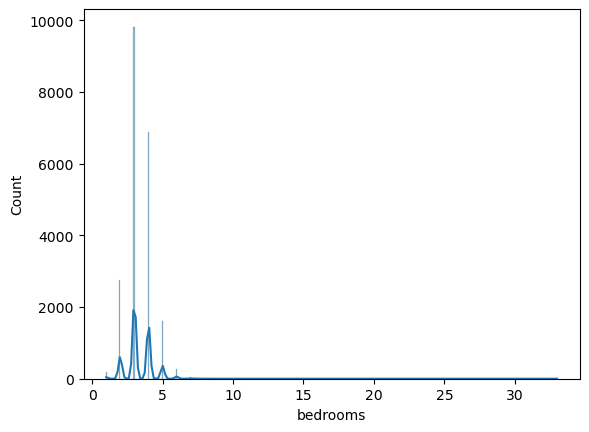

bathrooms


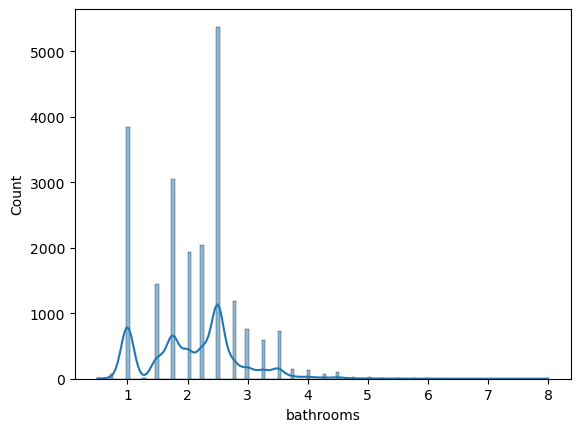

sqft_living


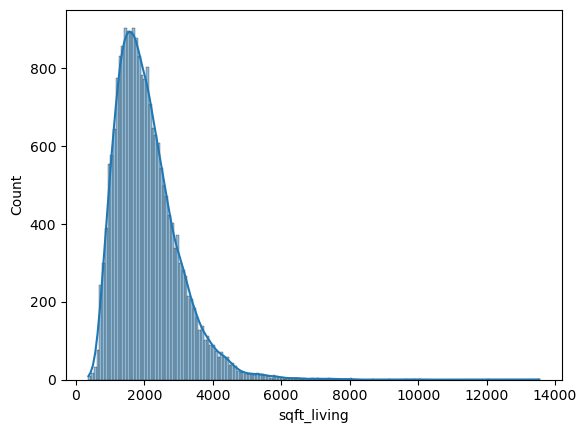

sqft_lot


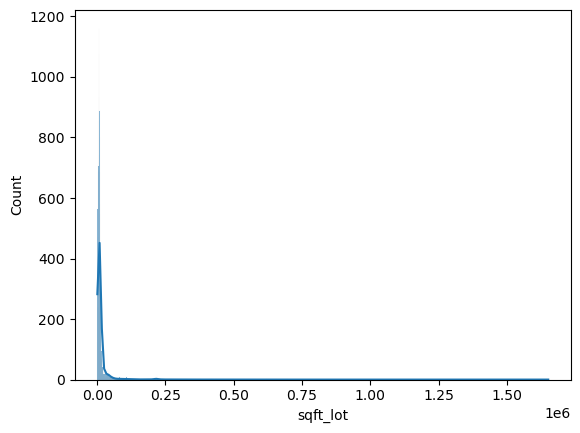

floors


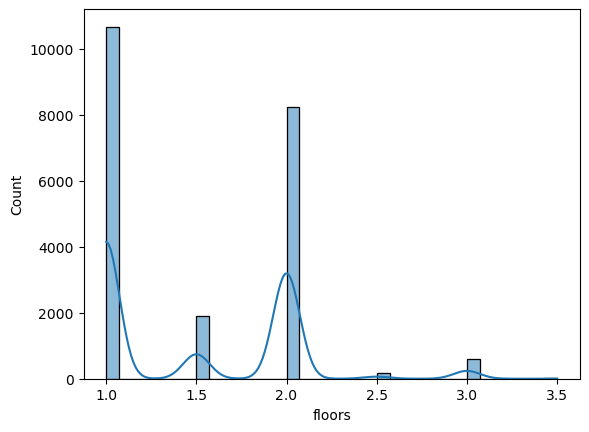

waterfront


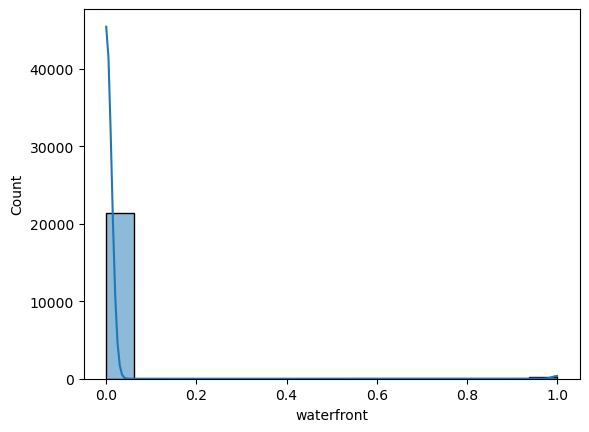

view


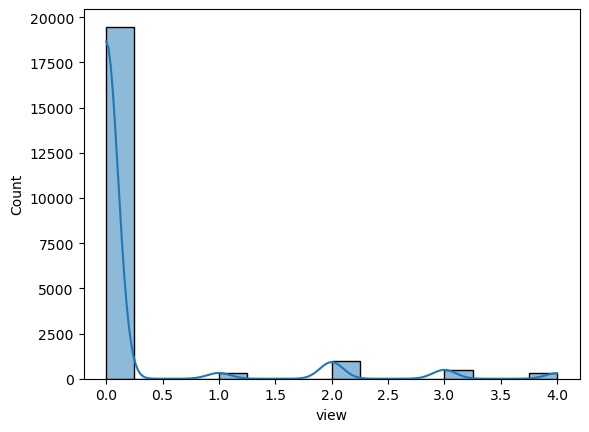

condition


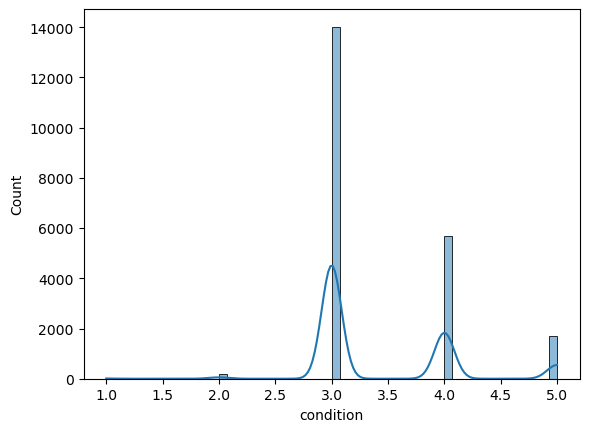

grade


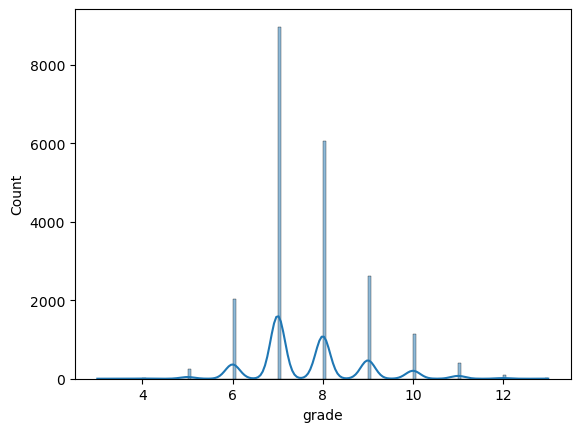

sqft_above


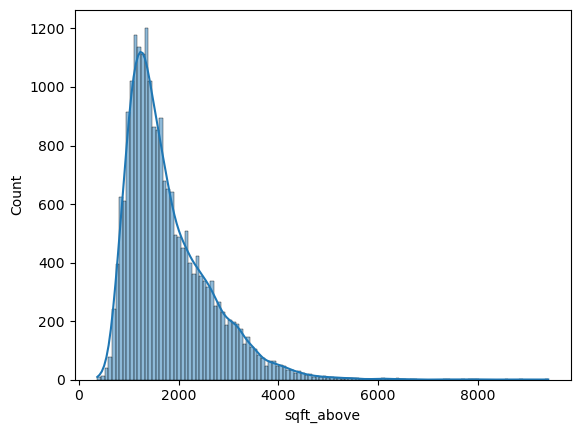

sqft_basement


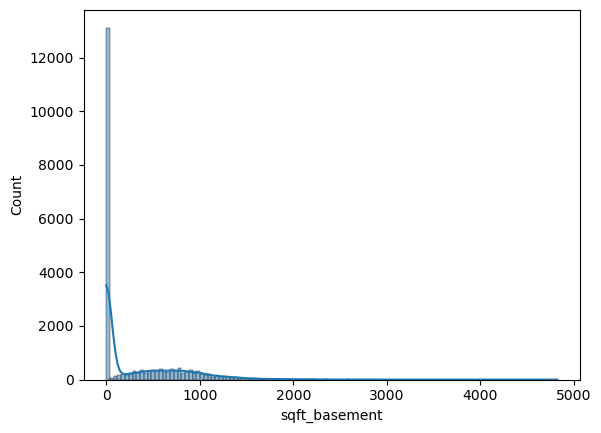

yr_built


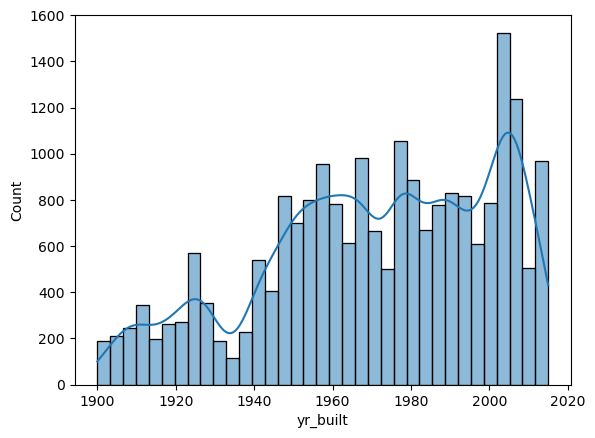

yr_renovated


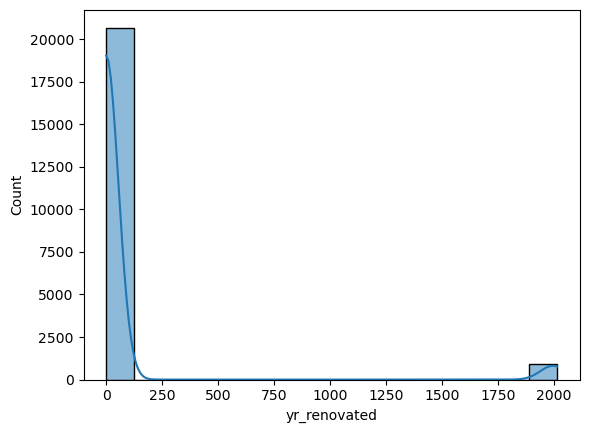

zipcode


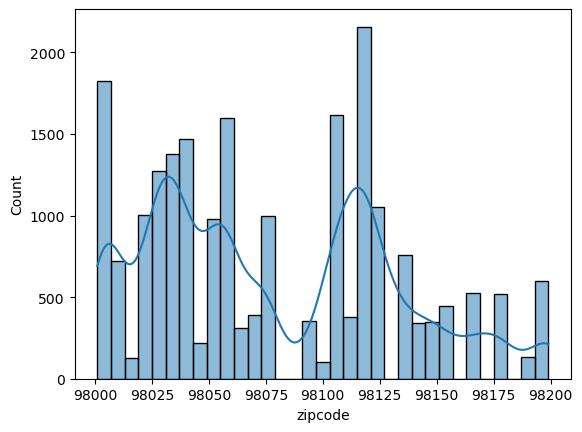

lat


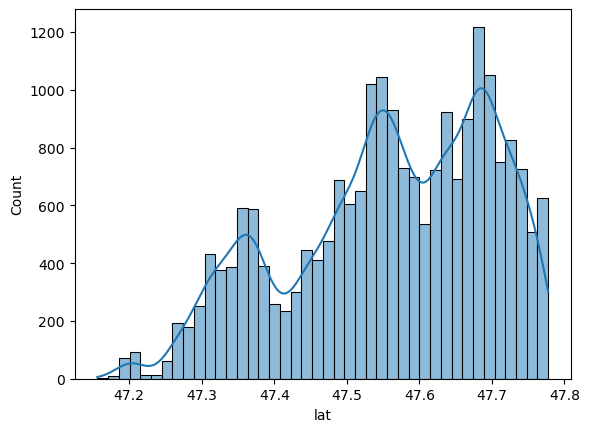

long


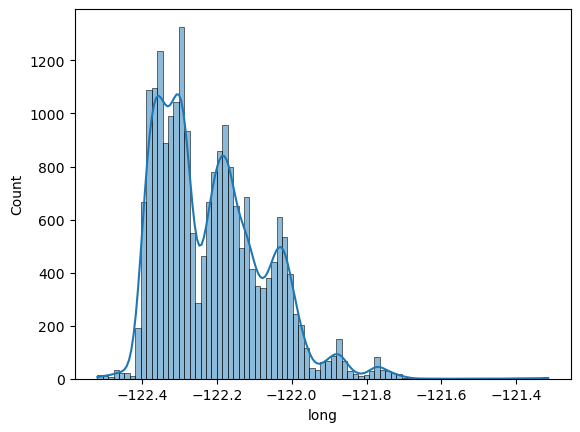

sqft_living15


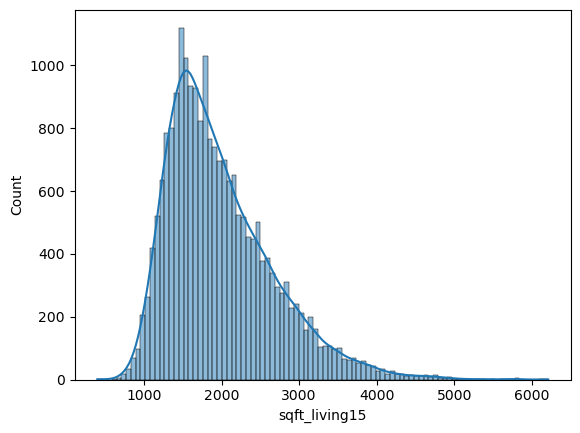

sqft_lot15


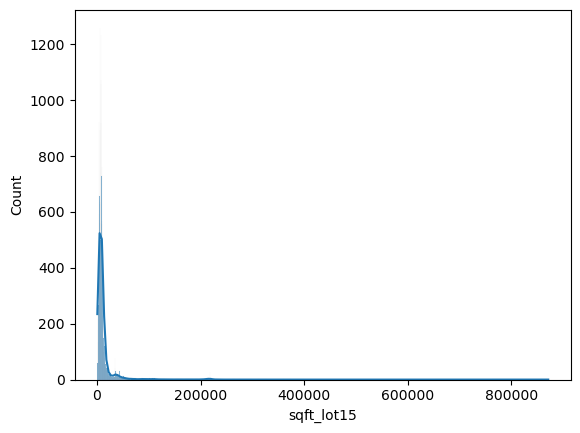

price


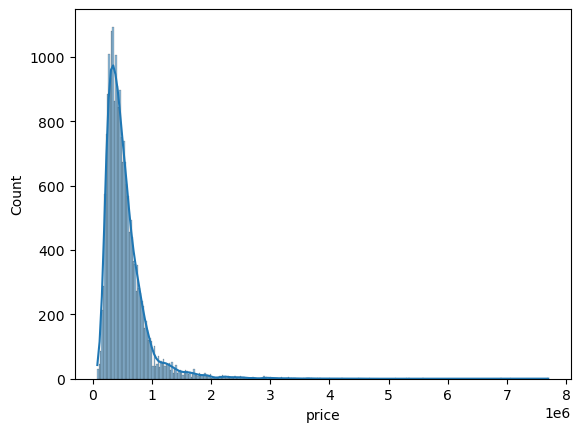

In [228]:
for col in df_num:
    print(col)
    sns.histplot(df_num[col], kde=True)
    plt.show()

### Observations:
#### waterfront - binary column, most values 0 / No
#### discrete values:
* bedrooms, bathrooms, floors, view, condition, grade:
    * bedrooms and grade are the closest to a normal distribution out of the discrete columns
* yr_built, yr_renovated, year/month (from date):
    * date information. General growth in number of houses progressing through the years. Most houses are not renovated. Dataset only contains house sold between 2014 and 2015.
#### continuous columns:
* square footage - sqft_living/..15, sqft_lot/..15, sqft_above, sqft_basement:
    * normally distributed with a skew to the right (positive side). This indicates the presence of a small group of homes and lots with much larger measurements in the different columns than the mean.
    * basement - adittionally, it is observed a very large spike of 0, indicating most homes do not have a basement
* price - normally distributed, skewed to the right, indicating the presence of outliers (a few very expensive homes)
* geographical information - coordinates and zipcode

## b. Identifying Outliers

bedrooms


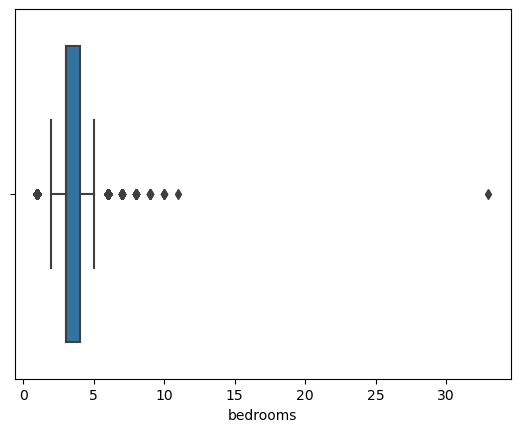

bathrooms


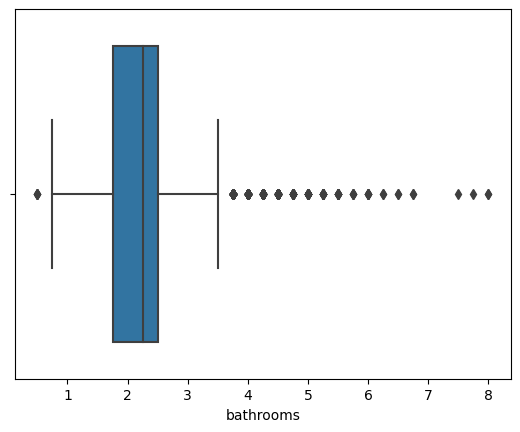

sqft_living


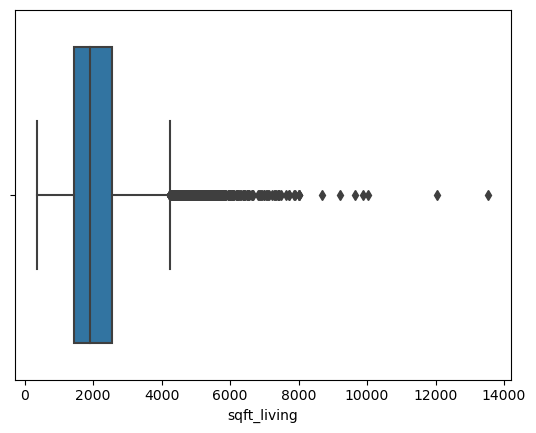

sqft_lot


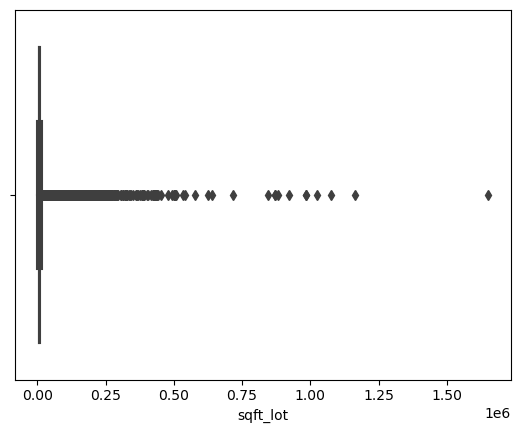

floors


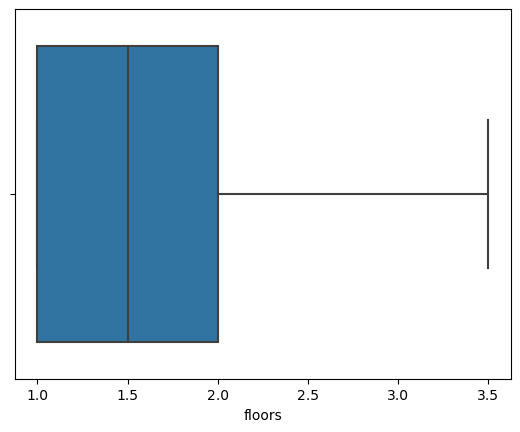

waterfront


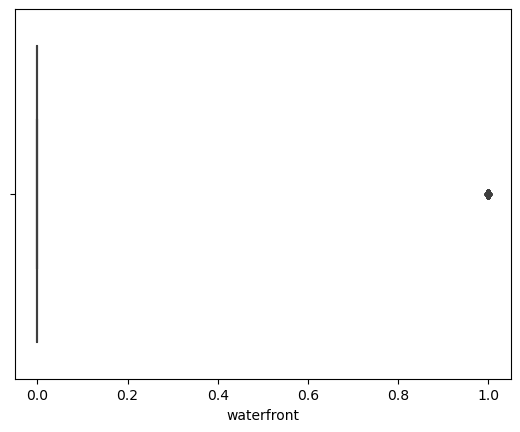

view


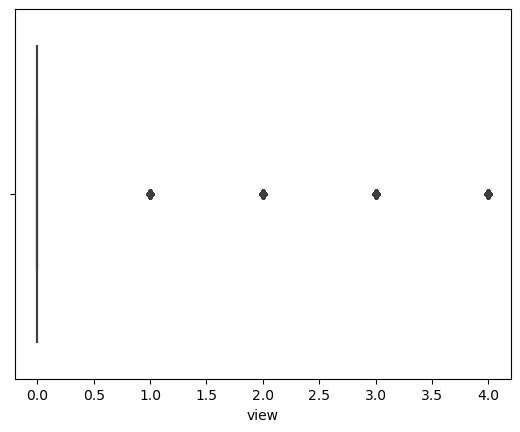

condition


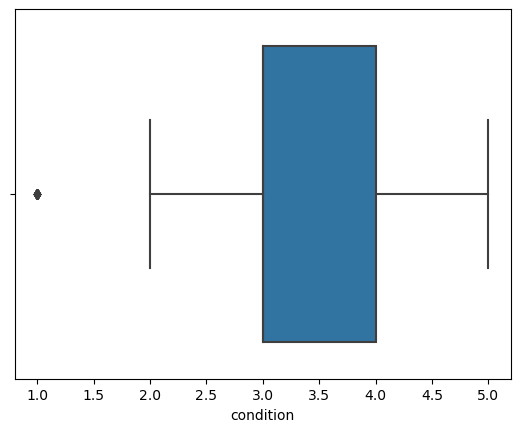

grade


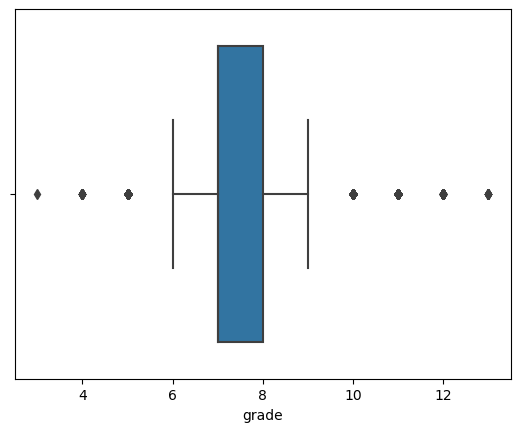

sqft_above


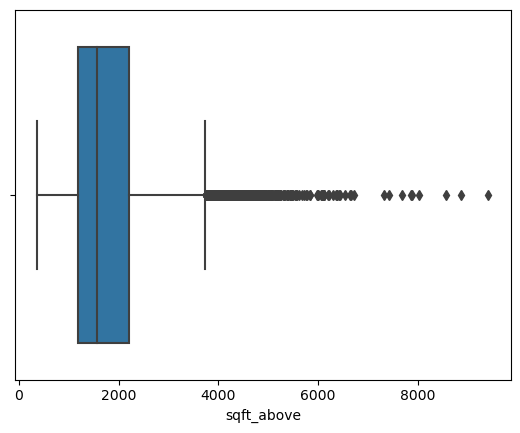

sqft_basement


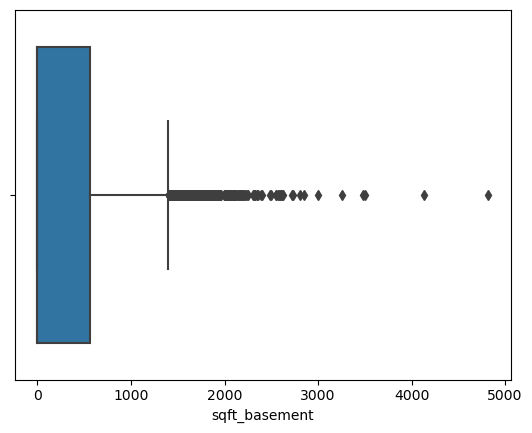

yr_built


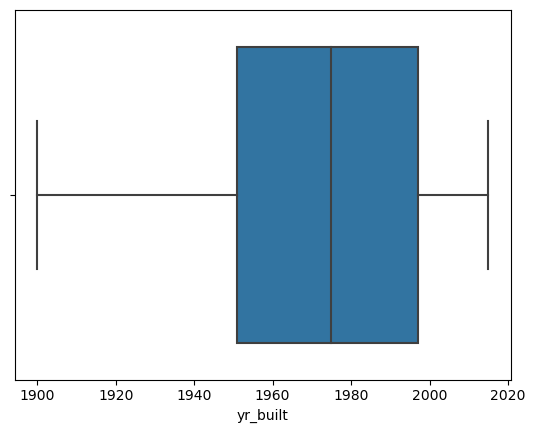

yr_renovated


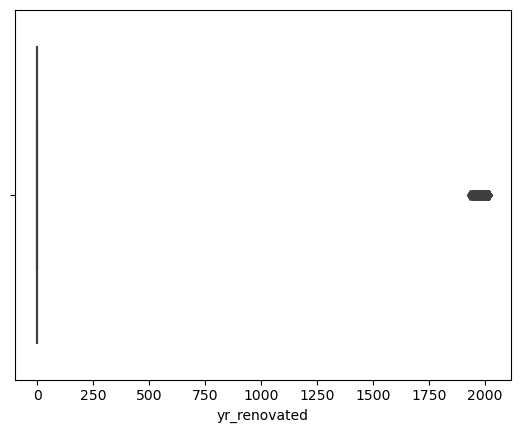

zipcode


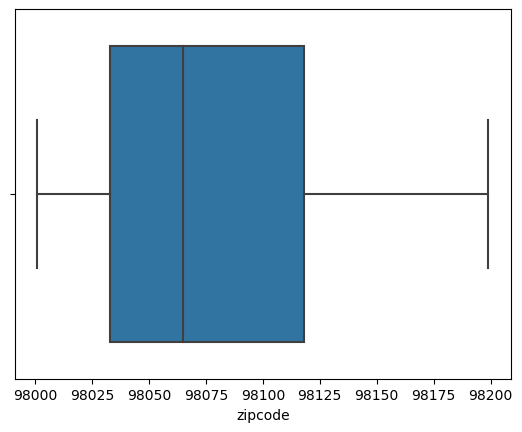

lat


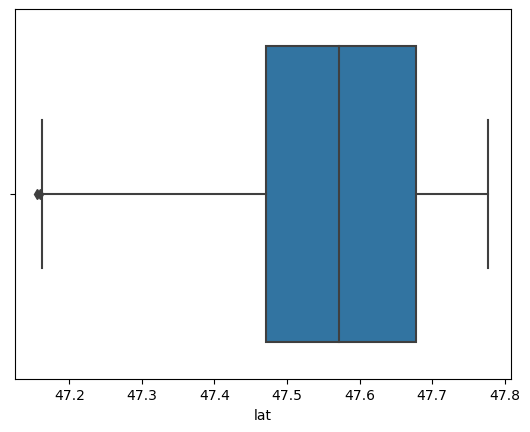

long


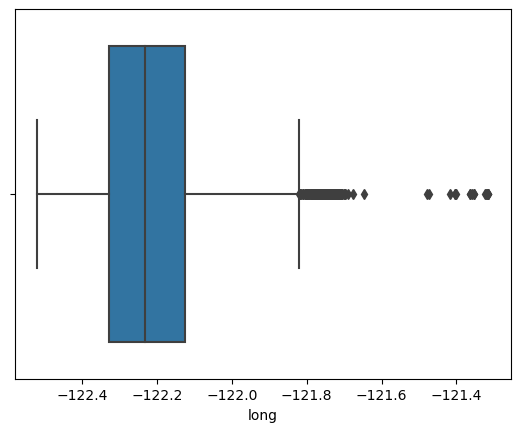

sqft_living15


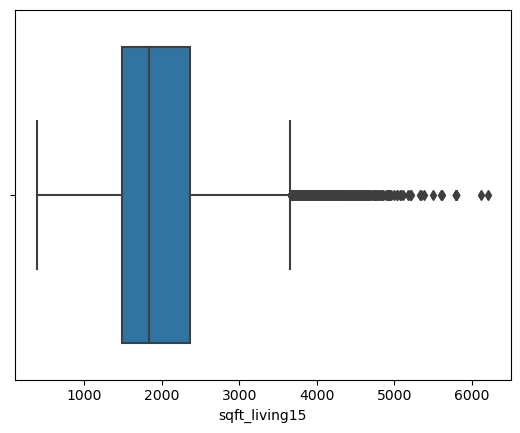

sqft_lot15


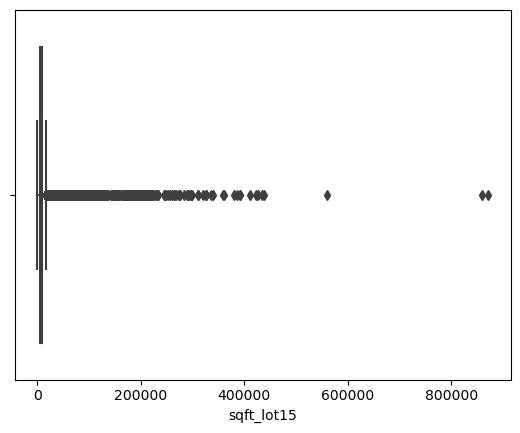

price


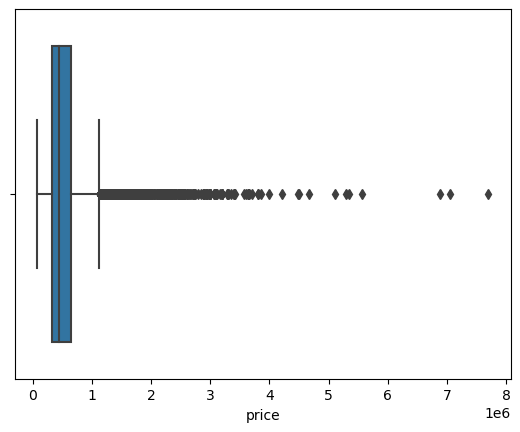

q_yr


TypeError: Horizontal orientation requires numeric `x` variable.

In [229]:
for col in df:
    print(col)
    sns.boxplot(x=df[col])
    plt.show()

### Observations:
#### Large presence of outliers across the dataset:
* This demonstrates some correlation between the features. For example, since there are several columns measuring square footage, it is likely that they share some of the same outliers.
* It is also representative of the real world where most homes in a given area are contained in a certain range of features such as price, size, condition, etc, and exceptions to this tend to be properties there are much larger, much more expensive, and in very small numbers.
#### Outliers identified in Price and square footage columns:
* lot footage (sqft_lot/..15) shows the largest presence of outliers. Could be explained by urban vs rural areas, where rural properties are usually larger in terms of lot size, and in opposition, apartment buildings are more common in urban areas.
* sqft_basement: most houses do not have a basement.
#### Other:
* bedrooms and bathrooms: small number of outliers mostly towards the positive side
* yr_renovated, waterfront: most houses are not renovate and are not by the waterfront.
* view: most houses have grade 0 in view and all other values are outliers. Possibly due to most houses being in dense urban areas.

## c. Analysing Correlations

C:\Users\grwc9\AppData\Local\Temp\ipykernel_9112\587200116.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


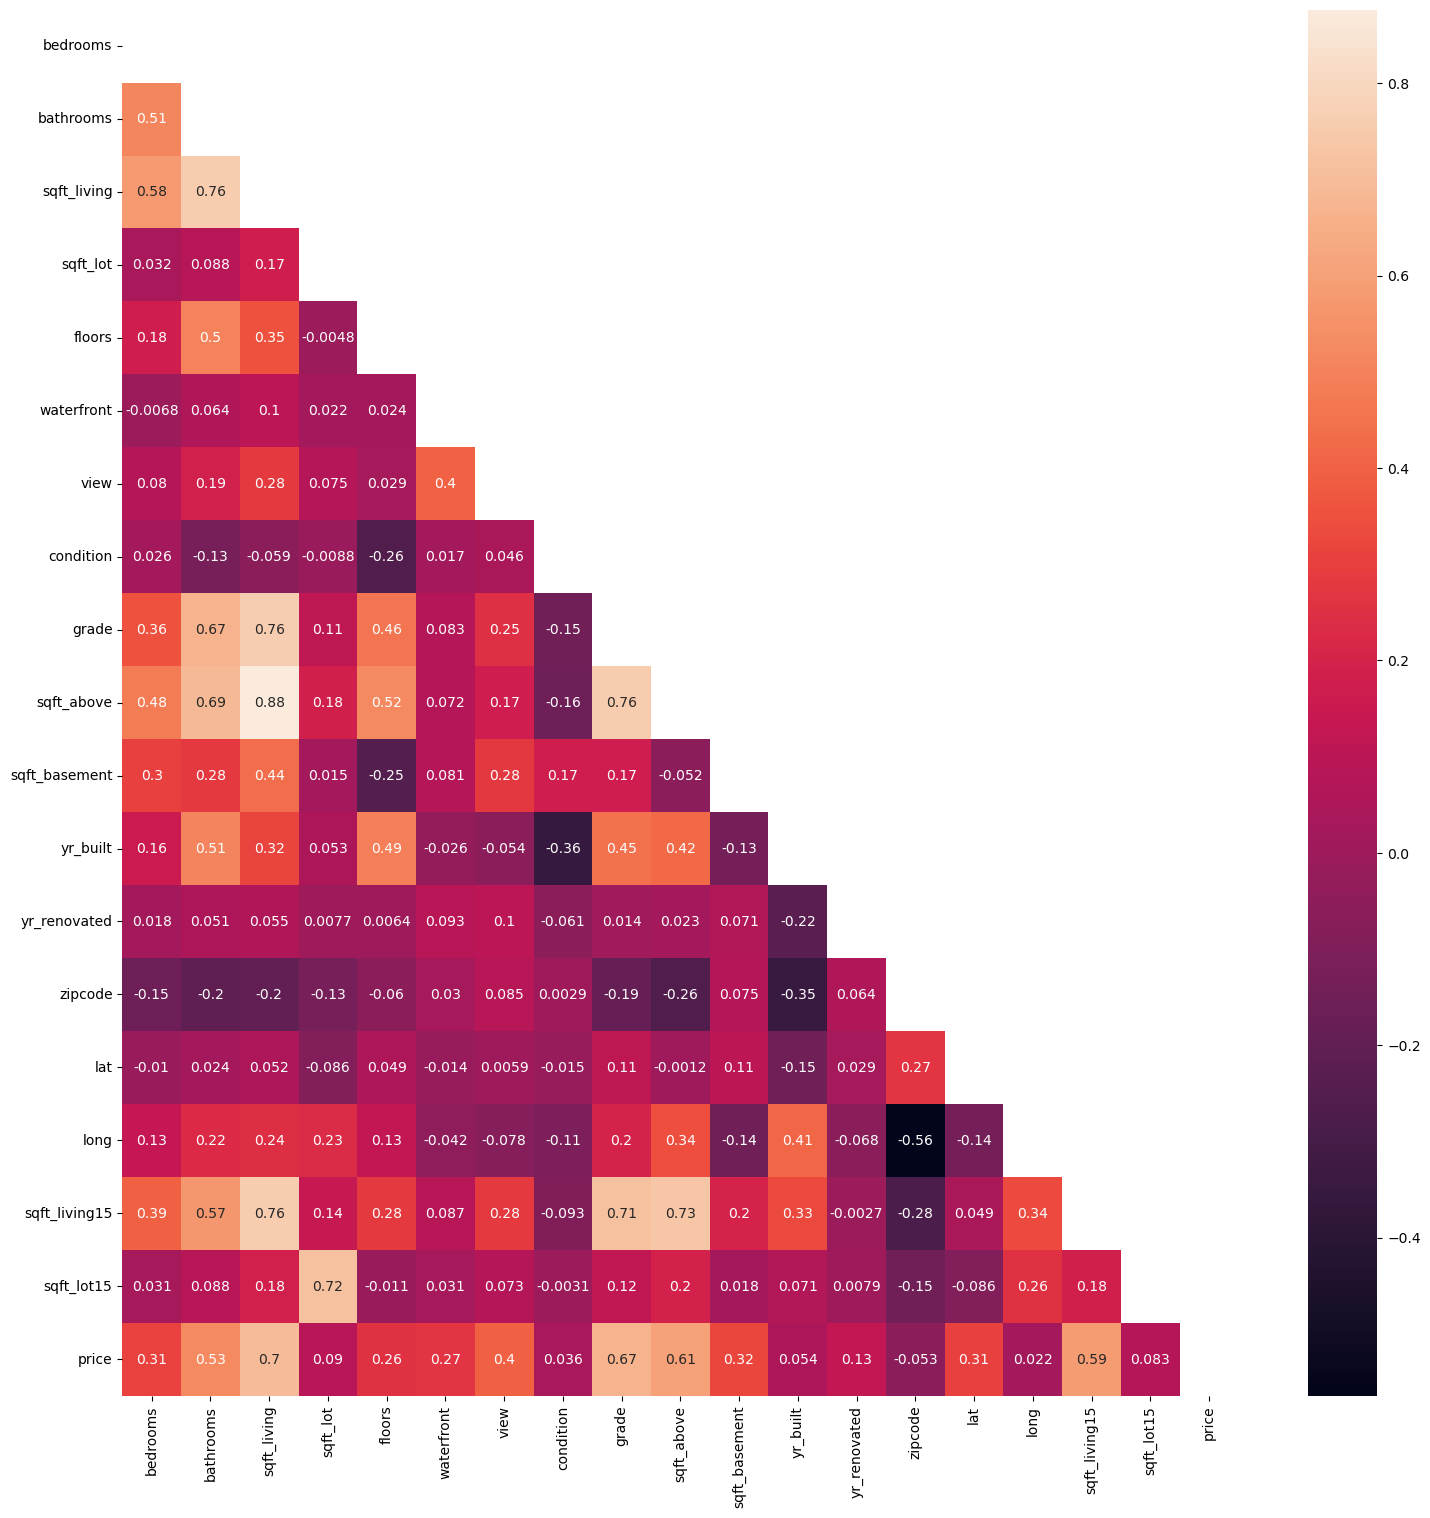

In [230]:
corr_matrix = df.corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(18, 18))
ax = sns.heatmap(corr_matrix, mask=mask, annot=True)
plt.show()

In [231]:
corr_matrix["price"].sort_values(ascending=False)

price            1.000000
sqft_living      0.701917
grade            0.667951
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
view             0.397370
sqft_basement    0.323799
bedrooms         0.308787
lat              0.306692
waterfront       0.266398
floors           0.256804
yr_renovated     0.126424
sqft_lot         0.089876
sqft_lot15       0.082845
yr_built         0.053953
condition        0.036056
long             0.022036
zipcode         -0.053402
Name: price, dtype: float64

### Observations:
#### Highest colinearity, above .75:
* sqft_living vs. grade / sqft_above / sqft_living15 / bathrooms 
* sqft_above vs. grade

#### Relevant colinearity, above .60:
* sqft_living15 / sqft_lot15 vs. sqft_living / sqft_lot
    * Explained by most houses not being renovated: these columns mostly contain the same values.
* square footage (above, living, lot, ..15), bathrooms and grade:
    * The different columns with square footage measurements are correlated, showing for example that a property in a larger lot will more likely be a larger house with a larger living room.
    * It also observed that the size of a house/property is taken into account by the King County grading.
    * The number of bathrooms appears correlated with the size of the property, and also to influence the grading score.
#### Relations with the target:
* The most relevant features for the price target (the columns with higher degree of colinearity) are:
    * sqft_living, sqft_living15, sqft_above and grade, showing that the size of the house is one of the biggest influences in the price.
    * location can be an important factor in house price, however it is not possible to evaluate through the matrix using zipcodes and coordinates.

## d. Identifying and Analysing Categorical Features

#### This dataset contains numerical columns that represent features that are categorical in nature:
* condition, grade, waterfront
* Additionally, yr_renotaved demonstrates that very few houses were renovated. As such it will be converted to a binary column. The original will be dropped as the information will not be significant for machine learning.
* The same is observed for houses with basements, a new binary column will be created but the original will be kept.

In [232]:
df['renovated'] = df['yr_renovated'].apply(lambda x: 0 if x == 0 else 1)
df = df.drop('yr_renovated', axis=1)

df_cat = df[['renovated','condition','grade','waterfront','sqft_basement']]

df_cat['basement'] = df_cat['sqft_basement'].apply(lambda x: 0 if x == 0 else 1)
df_cat = df_cat.drop('sqft_basement', axis=1)
df_cat

C:\Users\grwc9\AppData\Local\Temp\ipykernel_9112\2317662920.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat['basement'] = df_cat['sqft_basement'].apply(lambda x: 0 if x == 0 else 1)


renovated  condition  grade  waterfront  basement
0              0          3      7           0         0
1              1          3      7           0         1
2              0          3      6           0         0
3              0          5      7           0         1
4              0          3      8           0         0
...          ...        ...    ...         ...       ...
21592          0          3      8           0         0
21593          0          3      8           0         0
21594          0          3      7           0         0
21595          0          3      8           0         0
21596          0          3      7           0         0

[21597 rows x 5 columns]

0    20683
1      914
Name: renovated, dtype: int64


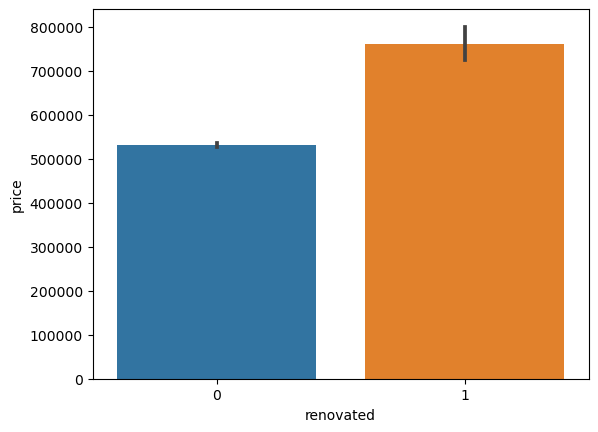

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64


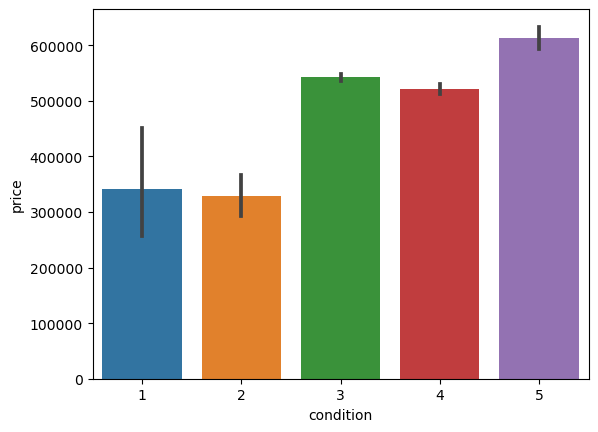

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64


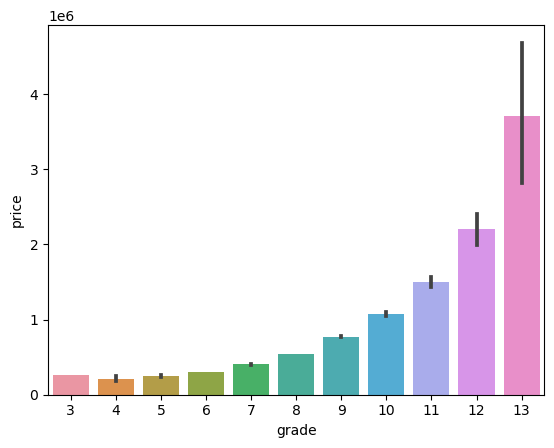

0    21434
1      163
Name: waterfront, dtype: int64


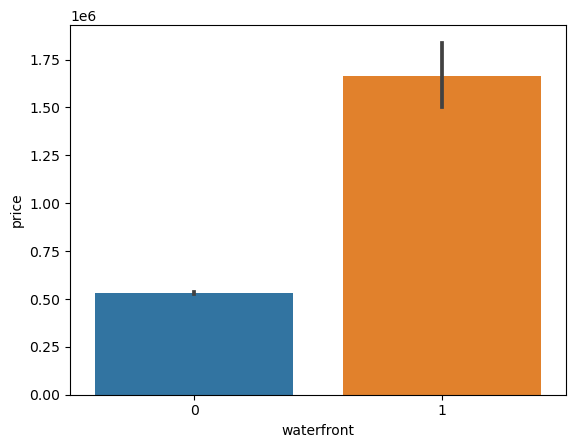

0    13110
1     8487
Name: basement, dtype: int64


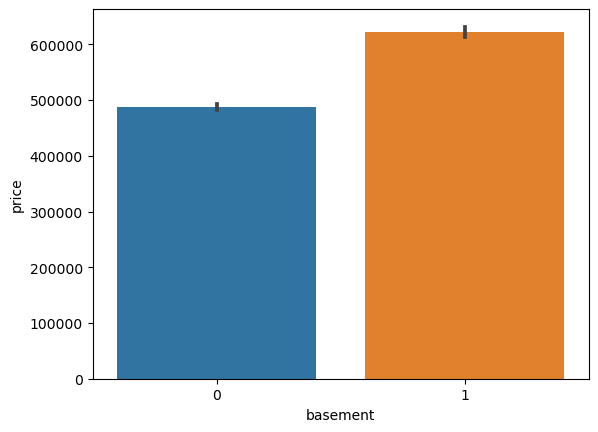

In [233]:
for col in df_cat:
    print(df_cat[col].value_counts())
    sns.barplot(x=col, y=df['price'], data=df_cat)
    plt.show()

### Observations:
#### Waterfront: Houses by the waterfront show a significant increase in price vs. not on the waterfront, however there is a very low sample size of these in the dataset.
#### Condition and Grade:
* It can be observed that these features are correlated to an increase in price of a property.
* **Low condition shows a significant drop in price**, while the highest condition shows a slight increase over the mean.
* **Grade correlates to an exponential increase in price** - previously it was observed that this grading system is strongly correlated with the other features that most correlate with the price target.
#### Basement: Small increase of average price on houses with basements vs. no basements.

# III. Applying Regression Models

## a. Basic Implementation

In [234]:
df = df.drop('q_yr', axis=1)
df2 = df.copy()

#### X/Y split

In [235]:
x = df2.drop(['price'], axis=1)
y = df2['price']

#### Train/Test Split

In [236]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#### Applying Linear Regression model and printing metrics

In [237]:
model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)

In [238]:
print("R2_score:", round(r2_score(y_test, predictions), 2))
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
mae = mean_absolute_error(y_test, predictions)
print("MAE:", mae)

R2_score: 0.69
MSE: 41663113503.65574
MAE: 125641.52420563487


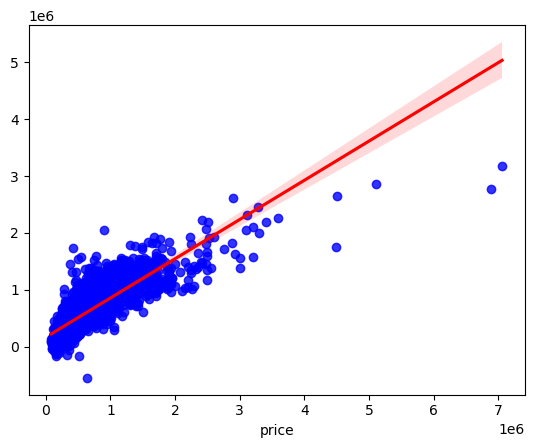

In [239]:
sns.regplot(x=y_test, y=predictions, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.show()

### Initial Results:
#### LinearRegression(), no pre-processing
* R2_score: 0.69
* MSE: 41661369977.392426
* MAE: 125639.56037812952

## b. Data pre-processing

#### Scaling features

In [240]:
scaler = StandardScaler()
scaler.fit(x)

x_std = scaler.transform(x)
x_std = pd.DataFrame(x_std, columns = x.columns)

R2_score: 0.69
MSE: 41663113503.65264
MAE: 125641.52420564175


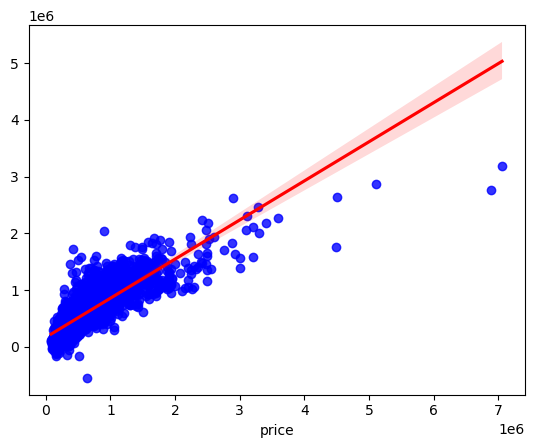

In [241]:
x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)

print("R2_score:", round(r2_score(y_test, predictions), 2))
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
mae = mean_absolute_error(y_test, predictions)
print("MAE:", mae)

sns.regplot(x=y_test, y=predictions, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.show()

### Results: No change
#### LinearRegression(), no pre-processing
* R2_score: 0.69
* MSE: 41661369977.392426
* MAE: 125639.56037812952
#### LinearRegression(), standard scaling
* R2_score: 0.69
* MSE: 41663113503.65264
* MAE: 125641.52420564175

In [242]:
df_log = df2[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'price']]

for col in df_log:
    df2[col] = np.log1p(df2[col])



R2_score: 0.76
MSE: 0.06440191631308197
MAE: 0.1953002067567601


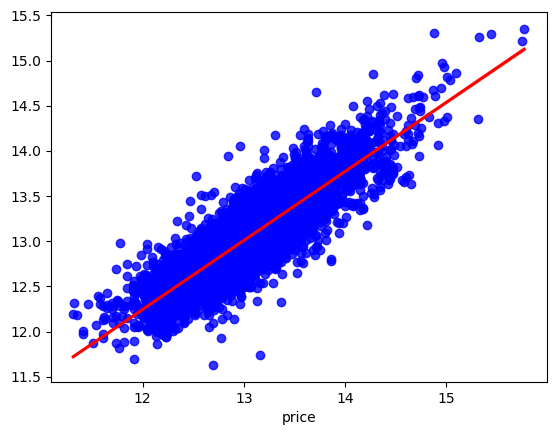

In [243]:
x = df2.drop(['price'], axis=1)
y = df2['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)

print("R2_score:", round(r2_score(y_test, predictions), 2))
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
mae = mean_absolute_error(y_test, predictions)
print("MAE:", mae)

sns.regplot(x=y_test, y=predictions, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.show()

### Results: Slight accuracy increase, R2 score from 0.69 to 0.76
#### LinearRegression(), no pre-processing
* R2_score: 0.69
* MSE: 41661369977.392426
* MAE: 125639.56037812952

#### LinearRegression(), log transform
* R2_score: 0.76
* MSE: 0.06440191631308197
* MAE: 0.1953002067567601

## c. Comparing Regression Models

In [246]:
df2 = df.copy()

R2_score: 0.7
MSE: 0.08162000583231692
MAE: 0.1984115071856904


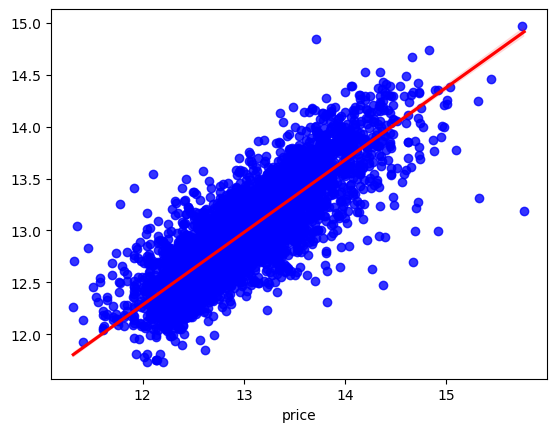

R2_score: 0.89
MSE: 0.031074212140825997
MAE: 0.12467973211604216


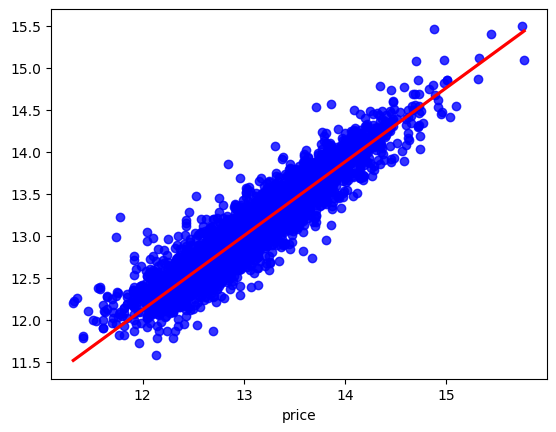

In [247]:
df_log = df2[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'price']]

for col in df_log:
    df2[col] = np.log1p(df2[col])

x = df2.drop(['price'], axis=1)
y = df2['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

reg_models = [KNeighborsRegressor(), RandomForestRegressor()]
for m in reg_models:
    model = m
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)

    print("R2_score:", round(r2_score(y_test, predictions), 2))
    mse = mean_squared_error(y_test, predictions)
    print("MSE:", mse)
    mae = mean_absolute_error(y_test, predictions)
    print("MAE:", mae)

    sns.regplot(x=y_test, y=predictions, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
    plt.show()

### Results: RandomForestRegressor() wields the greatest improvement in accuracy, to 0.89
#### LinearRegression(), log transform (best so far)
* R2_score: 0.76
* MSE: 0.06440191631308197
* MAE: 0.1953002067567601
#### KNeighborsRegressor(), log transform
* R2_score: 0.7
* MSE: 0.08162000583231692
* MAE: 0.1984115071856904
#### RandomForestRegressor(), log transform
* R2_score: 0.89
* MSE: 0.031074212140825997
* MAE: 0.12467973211604216

## d. Feature Selection - Removing Collinearity

In [256]:
df_no_coll = df.drop(['sqft_above','zipcode','sqft_basement'],axis=1)

R2_score: 0.88
MSE: 0.03178812015799152
MAE: 0.12618837910974115


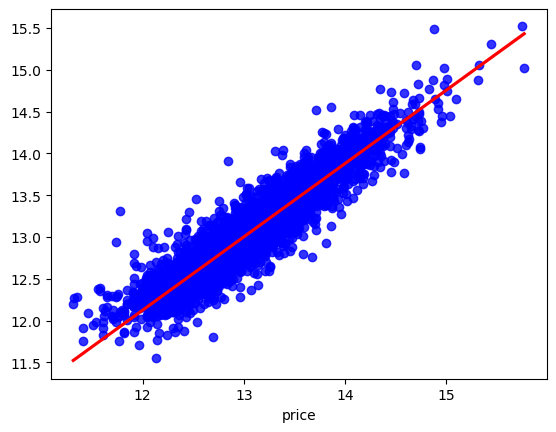

In [257]:
df_log = df_no_coll[['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'price']]

for col in df_log:
    df_no_coll[col] = np.log1p(df_no_coll[col])

x = df_no_coll.drop(['price'], axis=1)
y = df_no_coll['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

model = RandomForestRegressor()
model.fit(x_train, y_train)
predictions = model.predict(x_test)

print("R2_score:", round(r2_score(y_test, predictions), 2))
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
mae = mean_absolute_error(y_test, predictions)
print("MAE:", mae)

sns.regplot(x=y_test, y=predictions, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.show()

### Results: Collinearility in columns removed was not significant. Almost no change in accuracy (slight drop)
#### RandomForestRegressor(), log transform (best so far)
* R2_score: 0.89
* MSE: 0.031074212140825997
* MAE: 0.12467973211604216
#### RandomForestRegressor(), log transform, no collinearility
* R2_score: 0.88
* MSE: 0.03178812015799152
* MAE: 0.12618837910974115

# Conclusion

#### The most important features in the dataset that help to predict the price of a house are the following:
* Square footage (living, living15 and above), only considering the house and not the size of the lot neither the basement (for houses that have one).
* Grade. As previously, the grading system is correlated and as such appears to take into account other important features present in the data, such as the square footage.
* Bathrooms. According to the correlation matrix, there is 52% correlation between price and num of bathrooms of a house.
#### RandomForestRegressor wielded the best results out of the machine learning models tested, paired with log transforming the dataset to reduce the influence the outliers can have on the results. The accuracy of the model is suited to predict the price a house will be sold.